In [1]:
import tensorflow as tf
import neural_tangents as nt
from neural_tangents import stax
import jax.numpy as np
from jax import random

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def find_h(N, L, d, n=1, bias=True):
    # Modified from https://github.com/mariogeiger/nn_jamming/blob/master/constN.py
    # TODO: bias=False?
    '''
        For a network with: 
        
        d input dimensionality, 
        L layers, 
        N total parameters, 
        n final outputs,
        
        this finds the corresponding width h 
    '''
    assert L >= 1

    if L == 1:
        # solve : N = h*(d+1) + n*(h+1)
        h = (N - n) / (d + n + 1)
    else:
        # solve : N = h*(d+1) + (L-1)*h*(h+1) + n*(h+1)
        h = -(d+L+n - ((d+L+n)**2 + 4*(L-1)*(N-n))**.5)/(2*(L-1))
    return round(h)

def find_N(h, L, d, n=1):
    return h*(d+1) + (L-1)*h*(h+1) + n*(h+1)

In [30]:
P = 1000
d = 50
L = 2

N = 20000

h = find_h(N, L, d)

In [31]:
N/P, h

(20.0, 117)

In [32]:
init_fn, apply_fn, kernel_fn_inf = stax.serial(
    *[stax.Dense(h), stax.Erf()]*L,
    stax.Dense(1)
)

In [33]:
trainkey, testkey, kernelkey = random.split(random.PRNGKey(1), num=3)
x_train = random.normal(trainkey, (P, d))
x_test = random.normal(testkey, (P, d))

# project to hyper-sphere of radius sqrt(d)
x_train = np.sqrt(d) * x_train / np.linalg.norm(x_train, axis = 1, keepdims=True)
x_test = np.sqrt(d) * x_test / np.linalg.norm(x_test, axis = 1, keepdims=True)

In [34]:
_, init_params = init_fn(kernelkey, x_train.shape)

In [35]:
N_actual = sum(sum([[params.size for params in layer] for layer in init_params], []))
N, N_actual

(20000, 19891)

In [36]:
kernel_fn = nt.empirical_kernel_fn(apply_fn)

In [37]:
gram_ntk = kernel_fn(x_train, x_train, init_params, get='ntk')

In [38]:
eigs = np.linalg.eigvalsh(gram_ntk[:,:, 0, 0])

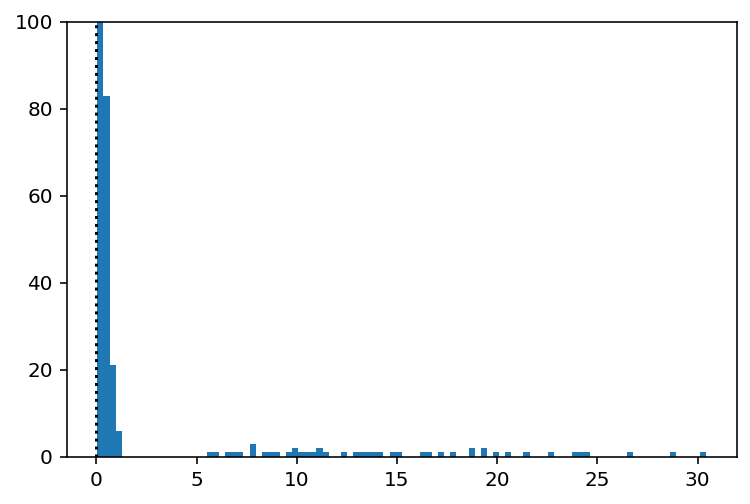

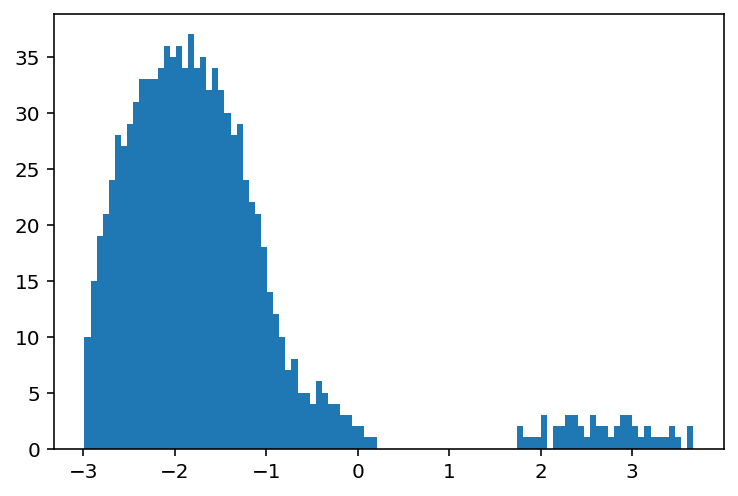

In [39]:
plt.figure()
hist = plt.hist(eigs[:-4], 100)
plt.axvline(0, color='k', linestyle=':')
plt.ylim(0,100)

plt.figure()
loghist = plt.hist(np.log(eigs), 100)

# Do linearized neural networks exhibit jamming?

In [40]:
force = lambda f, y: 1/2 - f*y
loss = lambda fx, y_hat: np.mean(1/2 * np.maximum(0, force(fx, y_hat))**2)

In [41]:
y_train = random.bernoulli(trainkey, p=.5, shape=(P,1))*2 - 1

In [42]:
g_dd = kernel_fn(x_train, x_train, init_params, get='ntk')

In [43]:
predict_fn = nt.predict.gradient_descent(g_dd, y_train, loss)
# predict_fn = nt.predict.gradient_descent_mse(g_dd, y_train)

In [44]:
train_time = 5e4

fx_train_initial = apply_fn(init_params, x_train)

fx_train_final = predict_fn(
    train_time, 
    fx_train_initial
)
loss_val = loss(fx_train_final, y_train)
loss_val

DeviceArray(0.0001249, dtype=float32)

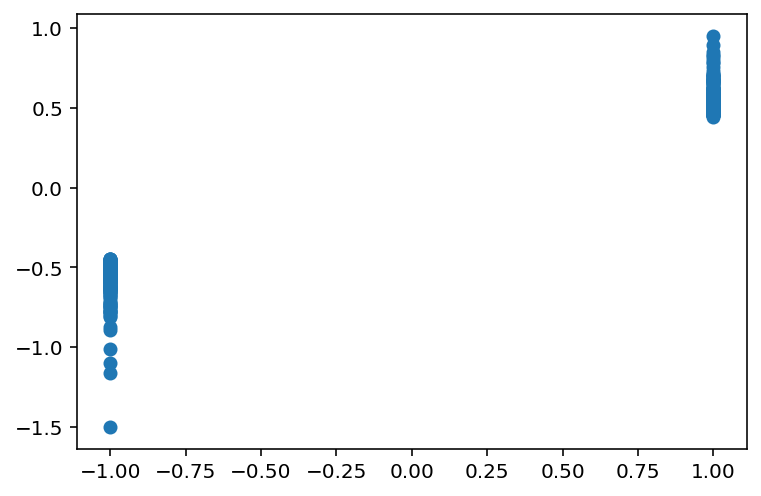

In [45]:
plt.scatter(y_train, fx_train_final)

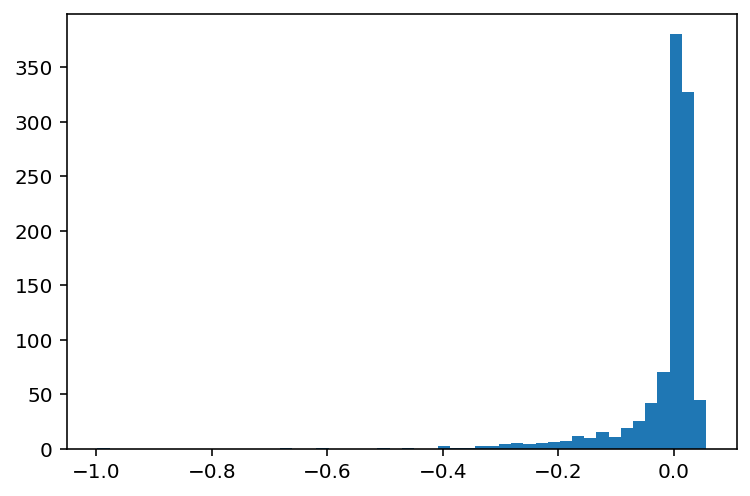

In [46]:
forces = np.ravel(force(fx_train_final, y_train))

hist = plt.hist(forces, 50)

In [47]:
N_del = sum(forces > 0)
N_del

700

In [48]:
overlaps = forces[forces > 0]
gaps = forces[forces <= 0]

len(overlaps), len(gaps)

(700, 300)

## Training loop

In [49]:
from tqdm import notebook as tqdm

In [50]:
losses = []
N_dels = []
overlaps = []
gaps = []
Ns = []

for hi in tqdm.trange(h, 0, -1):
    Ni = find_N(hi, L, d)
    Ns.append(Ni)

    init_fn, apply_fn, kernel_fn_inf = stax.serial(
        *[stax.Dense(hi), stax.Erf()]*L,
        stax.Dense(1)
    )
    _, init_params = init_fn(kernelkey, x_train.shape)

    kernel_fn = nt.empirical_kernel_fn(apply_fn)

    g_dd = kernel_fn(x_train, x_train, init_params, get='ntk')

    predict_fn = nt.predict.gradient_descent(g_dd, y_train, loss)
#     predict_fn = nt.predict.gradient_descent_mse(g_dd, y_train)



    fx_train_initial = apply_fn(init_params, x_train)
    fx_train_final = predict_fn(
        train_time, 
        fx_train_initial
    )

    loss_val = loss(fx_train_final, y_train)
    forces = np.ravel(force(fx_train_final, y_train))

    N_del = sum(forces > 0)
    overlap = forces[forces > 0]
    gap = forces[forces <= 0]
    
    losses.append(loss_val)
    N_dels.append(N_del)
    overlaps.append(overlap)
    gaps.append(gap)

(array([  5.,   2.,  19.,  44.,  68., 494., 342.,  16.,   4.,   6.]),
 array([-0.19270694, -0.07509209,  0.04252277,  0.16013762,  0.27775246,
         0.39536732,  0.5129822 ,  0.63059705,  0.74821186,  0.8658267 ,
         0.9834416 ], dtype=float32),
 <a list of 10 Patch objects>)

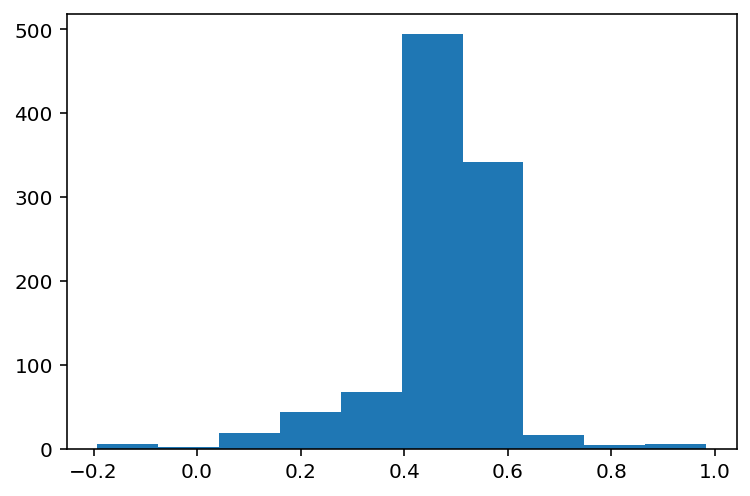

In [77]:
plt.hist(forces)

In [51]:
losses = np.array(losses)
N_dels = np.array(N_dels)
Ns = np.array(Ns)
overlaps = [np.array(overlap) for overlap in overlaps]
gaps = [np.array(gap) for gap in gaps]

In [52]:
N_dels

DeviceArray([ 700,  664,  715,  669,  701,  708,  684,  704,  693,  715,
              661,  688,  679,  680,  671,  681,  680,  675,  656,  663,
              701,  695,  709,  693,  707,  674,  700,  706,  713,  726,
              709,  667,  704,  679,  687,  694,  715,  710,  712,  663,
              677,  700,  716,  726,  736,  705,  707,  749,  689,  699,
              718,  684,  712,  718,  752,  754,  779,  745,  754,  736,
              711,  758,  753,  740,  768,  761,  783,  778,  765,  763,
              775,  785,  802,  805,  829,  835,  808,  878,  835,  834,
              821,  880,  869,  811,  850,  868,  889,  855,  912,  887,
              881,  879,  875,  883,  913,  892,  905,  892,  904,  865,
              887,  934,  924,  937,  889,  938,  945,  970,  986,  983,
              971,  994,  988,  988, 1000, 1000,  993], dtype=int32)

In [53]:
Ns

DeviceArray([19891, 19605, 19321, 19039, 18759, 18481, 18205, 17931,
             17659, 17389, 17121, 16855, 16591, 16329, 16069, 15811,
             15555, 15301, 15049, 14799, 14551, 14305, 14061, 13819,
             13579, 13341, 13105, 12871, 12639, 12409, 12181, 11955,
             11731, 11509, 11289, 11071, 10855, 10641, 10429, 10219,
             10011,  9805,  9601,  9399,  9199,  9001,  8805,  8611,
              8419,  8229,  8041,  7855,  7671,  7489,  7309,  7131,
              6955,  6781,  6609,  6439,  6271,  6105,  5941,  5779,
              5619,  5461,  5305,  5151,  4999,  4849,  4701,  4555,
              4411,  4269,  4129,  3991,  3855,  3721,  3589,  3459,
              3331,  3205,  3081,  2959,  2839,  2721,  2605,  2491,
              2379,  2269,  2161,  2055,  1951,  1849,  1749,  1651,
              1555,  1461,  1369,  1279,  1191,  1105,  1021,   939,
               859,   781,   705,   631,   559,   489,   421,   355,
               291,   229,   169, 

Text(0, 0.5, '$N_\\Delta/N$')

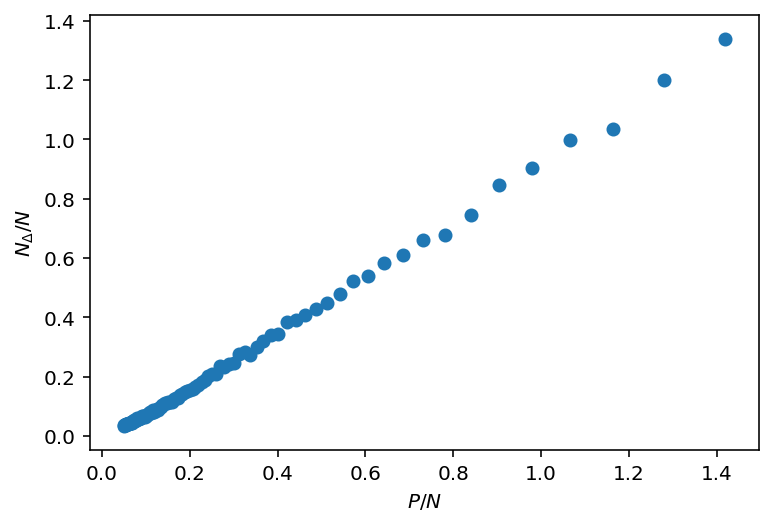

In [74]:
plt.scatter((P/Ns)[:-10], (N_dels/Ns)[:-10])
plt.xlabel('$P/N$')
plt.ylabel('$N_\Delta/N$')

(0, 1)

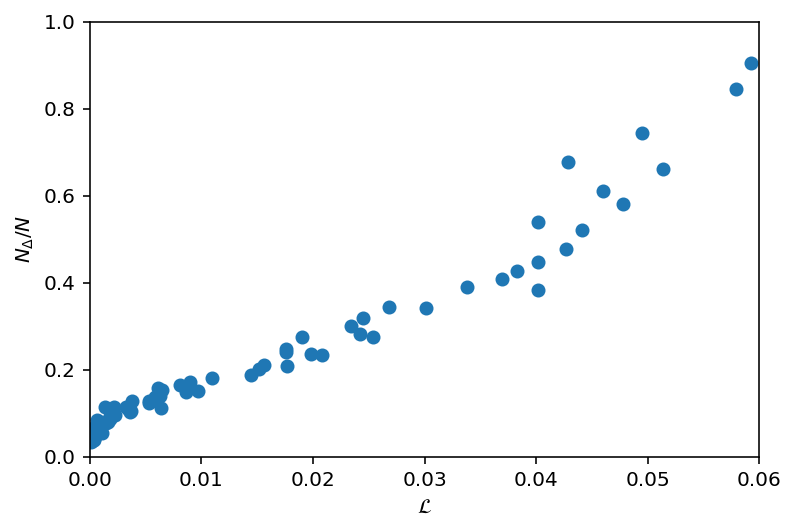

In [75]:
plt.scatter((losses), (N_dels/Ns))
plt.xlabel('$\mathcal{L}$')
plt.ylabel('$N_\Delta/N$')
plt.xlim(0,.06)
plt.ylim(0,1)

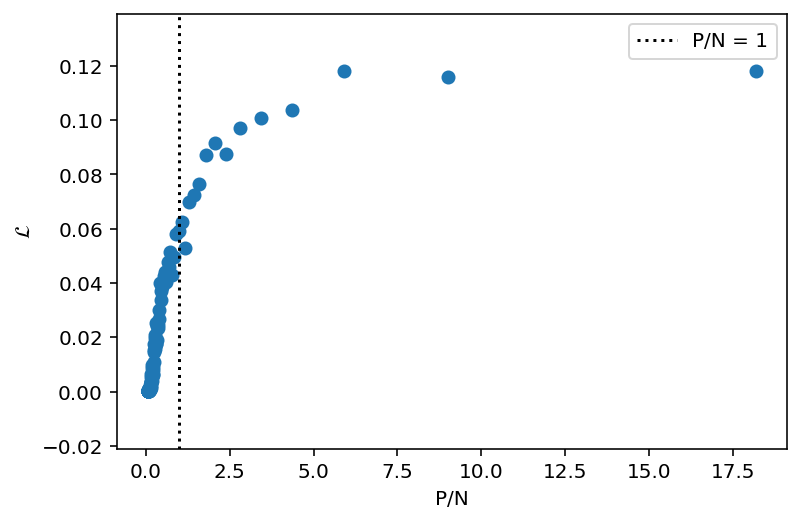

In [76]:
plt.scatter(P/Ns, losses)
plt.xlabel('P/N')
plt.ylabel('$\mathcal{L}$')
plt.axvline(1, color='k', linestyle =':', label = 'P/N = 1')
plt.legend()

Text(0, 0.5, '$\\Delta^+/N$')

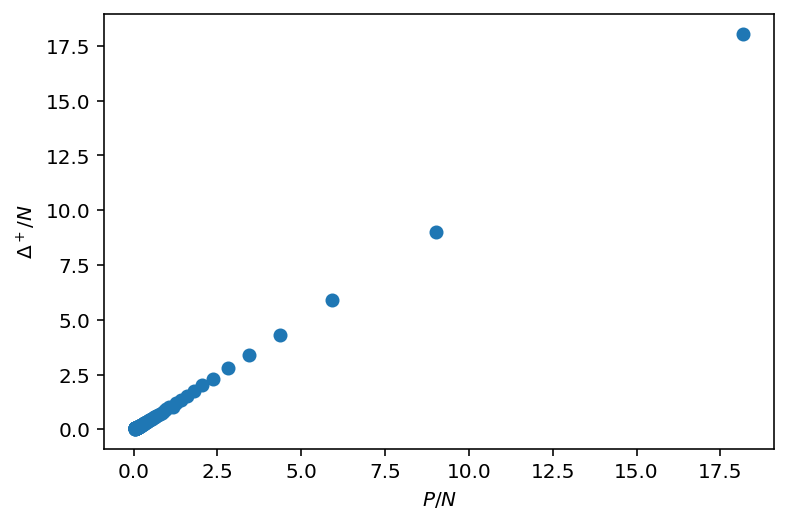

In [58]:
plt.scatter(P/Ns, np.array([len(o) for o in overlaps])/Ns)
plt.xlabel('$P/N$')
plt.ylabel('$\Delta^+/N$')

Text(0, 0.5, '$\\Delta^-/N$')

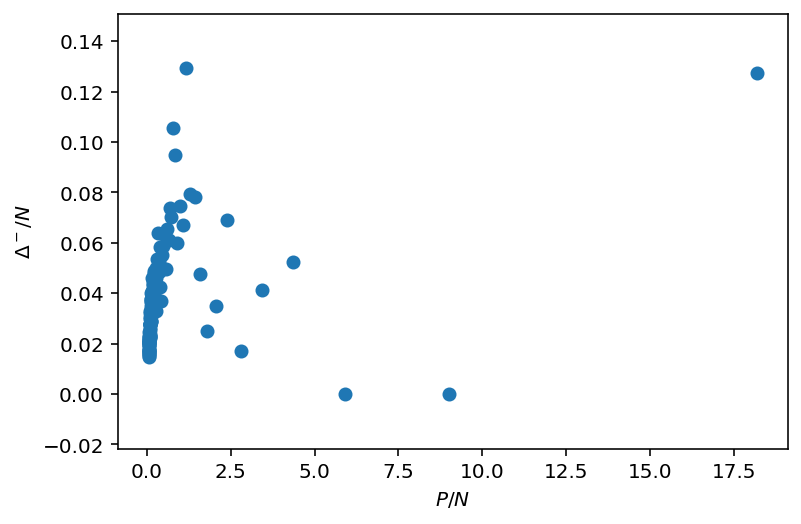

In [59]:
plt.scatter(P/Ns, np.array([len(g) for g in gaps])/Ns)
plt.xlabel('$P/N$')
plt.ylabel('$\Delta^-/N$')

Hessian?

In [362]:
from jax import jacfwd

In [405]:
H = jacfwd(apply_fn)(init_params, x_train)

In [406]:
[[inner.shape for inner in outer] for outer in H]

[[(1000, 1, 50, 77), (1000, 1, 77)],
 [],
 [(1000, 1, 77, 77), (1000, 1, 77)],
 [],
 [(1000, 1, 77, 1), (1000, 1, 1)]]

In [407]:
[[inner.shape for inner in outer] for outer in init_params]

[[(50, 77), (77,)], [], [(77, 77), (77,)], [], [(77, 1), (1,)]]

In [395]:
expansion = nt.taylor_expand(apply_fn, init_params, 2)

In [396]:
expansion(init_params, x_train)

DeviceArray([[-0.3941389 ],
             [ 0.16600257],
             [ 0.40947476],
             [-0.4098967 ],
             [-0.40962464],
             [-0.40989193],
             [ 0.40443587],
             [ 0.40991065],
             [ 0.4098583 ],
             [ 0.40941676],
             [ 0.40991047],
             [-0.4098075 ],
             [ 0.40979543],
             [-0.06310936],
             [ 0.40956348],
             [-0.38789985],
             [-0.00233371],
             [-0.2118917 ],
             [ 0.38547394],
             [-0.2335858 ],
             [ 0.4043545 ],
             [-0.4033173 ],
             [ 0.35477751],
             [-0.33867076],
             [-0.40937573],
             [ 0.40051457],
             [ 0.4098166 ],
             [ 0.32164308],
             [ 0.39276877],
             [ 0.34132722],
             [-0.4098441 ],
             [-0.11257735],
             [ 0.40953988],
             [ 0.40097496],
             [ 0.40973058],
             [-0.399